In [118]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch

In [119]:
#here set up the path of your file, a priori it should be on same directory
data = pd.read_csv("ibtracs.last3years.list.v04r00.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,,Year,,,,,,,degrees_north,degrees_east,...,second,kts,second,ft,nmile,nmile,nmile,nmile,kts,degrees
1,2016005N02187,2016,1,EP,CP,PALI,2016-01-05 06:00:00,NR,2.00000,-173.500,...,,,,,,,,,3,73
2,2016005N02187,2016,1,EP,CP,PALI,2016-01-05 09:00:00,NR,2.04500,-173.353,...,,,,,,,,,3,71
3,2016005N02187,2016,1,EP,CP,PALI,2016-01-05 12:00:00,NR,2.10000,-173.200,...,,,,,,,,,3,67
4,2016005N02187,2016,1,EP,CP,PALI,2016-01-05 15:00:00,NR,2.17750,-173.042,...,,,,,,,,,4,56


In [120]:
for col in data.columns: 
    print(col) 

SID
SEASON
NUMBER
BASIN
SUBBASIN
NAME
ISO_TIME
NATURE
LAT
LON
WMO_WIND
WMO_PRES
WMO_AGENCY
TRACK_TYPE
DIST2LAND
LANDFALL
IFLAG
USA_AGENCY
USA_ATCF_ID
USA_LAT
USA_LON
USA_RECORD
USA_STATUS
USA_WIND
USA_PRES
USA_SSHS
USA_R34_NE
USA_R34_SE
USA_R34_SW
USA_R34_NW
USA_R50_NE
USA_R50_SE
USA_R50_SW
USA_R50_NW
USA_R64_NE
USA_R64_SE
USA_R64_SW
USA_R64_NW
USA_POCI
USA_ROCI
USA_RMW
USA_EYE
TOKYO_LAT
TOKYO_LON
TOKYO_GRADE
TOKYO_WIND
TOKYO_PRES
TOKYO_R50_DIR
TOKYO_R50_LONG
TOKYO_R50_SHORT
TOKYO_R30_DIR
TOKYO_R30_LONG
TOKYO_R30_SHORT
TOKYO_LAND
CMA_LAT
CMA_LON
CMA_CAT
CMA_WIND
CMA_PRES
HKO_LAT
HKO_LON
HKO_CAT
HKO_WIND
HKO_PRES
NEWDELHI_LAT
NEWDELHI_LON
NEWDELHI_GRADE
NEWDELHI_WIND
NEWDELHI_PRES
NEWDELHI_CI
NEWDELHI_DP
NEWDELHI_POCI
REUNION_LAT
REUNION_LON
REUNION_TYPE
REUNION_WIND
REUNION_PRES
REUNION_TNUM
REUNION_CI
REUNION_RMW
REUNION_R34_NE
REUNION_R34_SE
REUNION_R34_SW
REUNION_R34_NW
REUNION_R50_NE
REUNION_R50_SE
REUNION_R50_SW
REUNION_R50_NW
REUNION_R64_NE
REUNION_R64_SE
REUNION_R64_SW
REUNION_R

In [121]:
#allows to keep only specific columns
def select_data(data):
    return data[['SID', 'NUMBER', 'ISO_TIME', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'STORM_SPEED', 'STORM_DIR']]#, 'BASIN', 'NATURE']]

#convert columns to numeric values
#and interpolate missing values
def numeric_data(data):
    for i in ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'STORM_SPEED', 'STORM_DIR']:
        data[i]=pd.to_numeric(data[i],errors='coerce').astype('float64')
        data[i]=data[i].interpolate(method='linear')
    return data

# df0 is  cleaned data 
df0 = select_data(data)
df0 = numeric_data(df0)

/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [122]:
#to have one-hot encoding of basin and nature of the storm
def add_one_hot(data, df0):
    basin = pd.get_dummies(data['BASIN'],prefix='basin')
    basin.drop(columns=['basin_ '], inplace = True)
    nature = pd.get_dummies(data['NATURE'],prefix='nature')
    nature.drop('nature_ ', axis=1, inplace = True)
    frames = [df0, basin, nature]
    df0 = pd.concat(frames, axis = 1)
    return df0

In [123]:
#This code allows to get the maximum wind change in the last X hours.
def get_max_change(data, time, i):
    t = time//3
    try:
        val = max(data['WMO_WIND'][i-t:i])-min(data['WMO_WIND'][i-t:i])
    except:
        val = 'NaN'
    return val

#please specify a multiple of 3h for the time
def get_max_wind_change(data, time):
    df = data
    df['max_wind_change']=[get_max_change(data, time, i) for i in range(len(data))]
    return df

In [124]:
#to use in the future: computes the wind category
def sust_wind_to_cat_one_hot(wind):
    # maximum sustained wind in kt (knot)
    if wind<=33: cat='TD' # <=33
    elif wind<=63.:  cat='TS'
    elif wind <=82.: cat='H1'
    elif wind <=95.: cat='H2'
    elif wind <=112.: cat='H3'
    elif wind <=136.: cat='H4'    
    elif wind > 136. : cat='H5'
    else: cat = 'nan'  

    return cat

def sust_wind_to_cat_val(wind):
    # maximum sustained wind in kt (knot)
    if wind<=33: cat= 0 # <=33
    elif wind<=63.:  cat=1
    elif wind <=82.: cat=2
    elif wind <=95.: cat=3
    elif wind <=112.: cat=4
    elif wind <=136.: cat=5    
    elif wind > 136. : cat=6
    else: cat = 0  

    return cat

In [125]:
def add_storm_category_one_hot(data):
    df = pd.DataFrame()
    df['storm_category'] = [sust_wind_to_cat_one_hot(data['WMO_WIND'][i]) for i in range(len(data))]
    storm_cat = pd.get_dummies(df['storm_category'],prefix='storm_category')
    #storm_cat
    storm_cat.drop('storm_category_nan', axis=1, inplace=True)
    frames = [data, storm_cat]
    df0 = pd.concat(frames, axis = 1)
    #df0.drop('storm_category', axis=1)
    return df0

def add_storm_category_val(data):
    df = pd.DataFrame()
    df['storm_category'] = [sust_wind_to_cat_val(data['WMO_WIND'][i]) for i in range(len(data))]
    frames = [data, df]
    df0 = pd.concat(frames, axis = 1)
    #df0.drop('storm_category', axis=1)
    return df0

In [126]:
def sort_storm(data, min_wind, min_steps = 5, max_steps = 120):
    '''function to create dictionary of storm matrices
    arguments: 
    data we want to cut
    min_wind: the minimum wind speed to store data 
    '''
    #get unique storm_id:
    SID=pd.unique(data['SID']).tolist()
    #remove empty SID
    SID.remove(' ') 
    #create empty dictionary
    dict0={}
    ind = 0
    for i in range(len(SID)):
        #get data of a particular SID
        M = data.loc[data['SID'] == SID[i]]
        #cut off using min wind speed
        #TODO : cut everything before, ie look for the right date
        try:
            t = M.index[M['WMO_WIND']>= min_wind][0]
            t0 = M.index[0]
        except:
            t = 0
        N = M.loc[M['WMO_WIND'] >= min_wind]
        #save matrix in dict0
        if N.shape[0] > min_steps:
            ind+=1
            dict0.update({ind:M.iloc[t-t0:max_steps+t-t0]})
    return dict0

#storms is the dictionary all storm matrices
#storms = sort_storm(df0, min_wind=45, min_steps=15)

In [127]:
#Geographical difference features: i.e. feature_1(t) = feature(t)-feature(0)
    # features: LAT, LON, DIST2LAND
def geo_diff(dict0):
    dict1={}
    #loop over each dataframe
    for i in dict0:
        df=dict0[i]
        #reset index
        df.reset_index(inplace=True, drop=True)
        #calculate difference from t=0 
        df['LAT_1']= df['LAT'] - df['LAT'][0]
        df['LON_1']= df['LON'] - df['LON'][0]
        df['DIST2LAND_1']= df['DIST2LAND'] - df['DIST2LAND'][0]
        #substitute back to the dictionary
        dict1[i]=df
    return dict1

In [128]:
#instead of padding with 0, pad with latest values in loop
def pad_traj(dict0, max_steps, nan = False):
    dict1={}
    for t in dict0:
        num_steps = dict0[t].shape[0]
        steps2add = max_steps - num_steps
        if steps2add > 0:
            if nan:
                dict1[t] = pd.concat([dict0[t], pd.DataFrame([[np.nan] * dict0[t].shape[1]]*steps2add, columns=dict0[t].columns)], ignore_index=True)
            else:
                dict1[t] = pd.concat([dict0[t], pd.DataFrame([[0] * dict0[t].shape[1]]*steps2add, columns=dict0[t].columns)], ignore_index=True)                
            #dict1[t] = pd.concat([dict0[t], pd.DataFrame([dict0[t].tail(1)]*steps2add, columns=dict0[t].columns)], ignore_index=True)                       
        else:
            dict1[t] = dict0[t][:max_steps]
    return dict1

In [129]:
#function to calculate tensor shape
    #input: dictionary of storm data
def tensor_shape(dict0):
    #number of storms
    num_storms=len(dict0) - 1
    #number of features
    num_features=dict0[next(iter(dict0))].shape[1]  
    
    #to compute min and max number of steps
    t_max = 0 #initialise 
    t_min = 1000
    t_hist = []
    for i in dict0:
        t0 = dict0[i].shape[0]
        t_hist.append(t0)
        if  t0 > t_max:
            t_max = t0
        if t0 < t_min:
            t_min = t0
    print("There are %s storms with %s features, and maximum number of steps is %s and minimum is %s." %(num_storms,num_features,t_max, t_min))
    return num_storms, num_features, t_max, t_min, t_hist     
    
#call tensor_shape 
#m, n, t_max, t_min, t_hist = tensor_shape(d)

In [130]:
#create a tensor
def create_tensor(data, number_of_storms):
    tensor = data[1]
    for i in range(2,number_of_storms,1):
        tensor=np.dstack((tensor, data[i]))
    #return list of features 
    p_list = data[1].columns.tolist()
    return tensor, p_list

def repad(t):
    for i in range(t.shape[0]):
        if t[i][2][-1] == 0:
            ind = np.argmin(t[0][2])
            for j in range(ind,t.shape[2]):
                t[i,:,j]=t[i,:,ind-1]
    return t

In [170]:
def prepare_data(path = "ibtracs.last3years.list.v04r00.csv", max_wind_change = 12, min_wind = 50, min_steps = 15, max_steps = 120):
    data = pd.read_csv(path) 
    #select interesting columns
    df0 = select_data(data)
    #transform data from String to numeric
    df0 = numeric_data(df0)
    #add one-hot storm category
    df0 = add_storm_category_one_hot(df0)
    df0 = add_storm_category_val(df0)   
    #transform basin and nature of the storm into one-hot vector
    df0 = add_one_hot(data, df0)
    #add the max-wind-change column
    #df0 = get_max_wind_change(df0, max_wind_change)
    #get a dict with the storms with a windspeed greater to a treshold
    storms = sort_storm(df0, min_wind, min_steps)
    #add geo_difference columns
    #storms = geo_diff(storms)
    #pad the trajectories to a fix length
    d = pad_traj(storms, max_steps)
    #print the shape of the tensor
    m, n, t_max, t_min, t_hist = tensor_shape(d)
    #create the tensor
    t, p_list = create_tensor(d, m)
    #delete id and number of the storms
    t2=torch.Tensor(t[:,3:,:].astype('float64'))
    #match feature list 
    p_list = p_list[3:]
    #transpose time and sample
    t3=torch.transpose(t2,0,2)
    #replace 0 by latest values in the tensor
    t3 = repad(t3)
    return t3, p_list

In [171]:
from __future__ import print_function
import torch
import numpy as np
import torch.nn.functional as F

dtype = torch.float
device = torch.device("cpu")

In [172]:
#2 dimensional SVD 
def mat_svd(X,r,m,n,t):
    #Mode-1 folding
    X1= X.reshape(m,n*t)
    U,S,V= torch.svd(X1,some=True, compute_uv=True) 
    U1=U[:,:r]
    #Mode-2 folding
    X2= X.reshape(m*t,n) 
    U,S,V= torch.svd(X2,some=True, compute_uv=True) 
    V1=V[:,:r]
    return U1,V1

#calculate MAE:
def get_mae(tensor1,tensor2):
    error = (tensor1-tensor2).abs().sum().item()
    return error 


#Slice Iteration: for one iteration 
def slice_iteration(tensor,r,m,n,t):
    new_tensor = torch.empty((m,n,t)) 
    #get U,V
    U,V = mat_svd(tensor, r,m,n,t)
    
    #update tensor 
    UU = torch.mm(U,torch.t(U))
    VV = torch.mm(V,torch.t(V))
    for i in range(t):
        new_tensor[:,:,i] = torch.mm(torch.mm(UU, tensor[:,:,i]),VV) 
    return new_tensor 

In [173]:
#Slice Learning 
def slice_learning(tensor_train,r,max_iteration=50,convergence=0.001, plot=False):
    m,n,t = tensor_train.shape
    new_tensor = torch.empty(m,n,t) 
    old_tensor = tensor_train 
    mae_all=[]
    
    mae = convergence + 1 
    #Iterative slice learning 
    for i in range(max_iteration): 
        if mae > convergence: 
            new_tensor = slice_iteration(old_tensor,r,m,n,t)
            mae = get_mae(new_tensor,old_tensor) 
            mae_all.append(mae)
            old_tensor = new_tensor 
    
    #plot MAE difference between iterations   
    max_i = len(mae_all)

    print('Code stopped at iteration = %s, and mae difference = %s'%(max_i,mae_all[-1]))
    if plot:
        plt.plot(np.linspace(1,max_i,max_i),mae_all)
        plt.yscale('log')
        plt.show()
    return new_tensor 

#X_imputed = slice_learning(t3_test2,16)

#find the MAE difference between X_imputed and X_original
#print('The MAE between X_imputed and X_original is %s' %(get_mae(X_imputed,t3_test2)))

In [174]:
#Function to standardize and de_standardize data 
def standardize(tensor): 
    new_tensor = tensor.clone()
    #calculate along 2nd (python index) dimension 
    #std, mean = torch.std_mean(tensor[:,:k,:], dim=2)
    # @cynthia: I replaced your line by this one so that it works with my torch version
    std, mean = torch.std(tensor[:,:,:], dim=2), torch.mean(tensor[:,:,:], dim=2)
    t=tensor.shape[2]
    for i in range(t):
        #element wise division
        new_tensor[:,:,i] = torch.div((tensor[:,:,i] - mean),std)  
    #replace Nan with 0 
    new_tensor[new_tensor != new_tensor] = 0
    return new_tensor, mean, std

def de_standardize(tensor,mean,std):
    t=tensor.shape[2]
    new_tensor = tensor.clone()
    for i in range(t):
        #element wise multiplication
        new_tensor[:,:,i] = torch.mul(tensor[:,:,i] ,std) + mean 
    return new_tensor 

# a,m,std=standardize(x)
# b=de_standardize(a,m,std) 
# print('standardize',a )
# print('de_standardize', b)
   

In [175]:
#plot error bar chart
def plot_error(data, data_imputed, p_list,storm_id):#calculate error for all features for next 5 hour prediction: 
    error_5=[]
    error_10=[]
    error_15=[]
    for p in range(len(p_list)):
        error_v=np.abs(data_imputed[storm_id][p] - data[storm_id][p])
        error_5.append((error_v[time+4:time+6].sum()*(1/3)))#avg of time = 4,5,6
        error_10.append((error_v[time+9:time+11].sum()*(1/3)))
        error_15.append((error_v[time+14:time+16].sum()*(1/3)))
    
    #plotting error:
    ind = np.arange(len(p_list)) 
    width = 0.3 
    plt.bar(ind,error_5,width, label='t+5')
    plt.bar(ind+width,error_10,width, label='t+10')
    plt.bar(ind+2*width,error_15,width, label='t+15')
    plt.xticks(ind + width / 2, p_list)
    plt.title('Avg error for t+5 /10 /15 prediction, StormID=%s' %(storm_id))
    plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
    plt.legend(loc='best')
    plt.show()
    return 

In [176]:
#Testing function by deleting entries after time t for one particular storm  
def test(data, p_list, storm_id, time, r, p = 2):
    data0 = data.clone()
    
    #data0= delete one storm data for testing  
    for t in range(time,data.shape[2]):
        data0[storm_id,:,t] = data0[storm_id,:,time-1]
    
    #get_best_r(data2, 5, 21)
    
    #slice_learning 1: no_scale 
    X_imputed_0 = slice_learning(data0,r)
    
    #slice learning 2: normalize data 
    data1 = F.normalize(data0, dim = 2)
    X_imputed_1 = slice_learning(data1,r)
    #de_normalize
    scale = torch.div(data[:,:,:time],X_imputed_1[:,:,:time])
    scale_mean = torch.mean(scale, dim=2)
    for i in range(X_imputed_1.shape[2]):
        X_imputed_1[:,:,i] = torch.mul(X_imputed_1[:,:,i], scale_mean) 
    
#     #de_normalize 
#     
#     data = np.array(data)
#     scale =  []
#     for i in range(time-1):
#         scale.append(data[storm_id][p][i]/X_imputed_1[storm_id][p][i])
#     m = np.array(scale).mean()
    
    #slice_learning 3: standardize
    data2, mean, std = standardize(data0)
    X_imputed_2 = slice_learning(data2, r)
    #de_standardize 
    X_imputed_2= de_standardize(X_imputed_2, mean, std)
    
    #plot error:
    plot_error(data, X_imputed_1, p_list[:8],storm_id)
    
    #plot predicted feature p with various normalization methods: 
    l = [i for i in range(data.shape[2])]
    plt.plot(l, X_imputed_0[storm_id][p], label='imputed_no_scale')
    plt.plot(l, (X_imputed_1[storm_id][p]   ),label='imputed_normalize')
    plt.plot(l, X_imputed_2[storm_id][p], label='imputed_standardize')
    plt.plot(l, data[storm_id][p],label='real')
    plt.axvline(x=time)
    plt.legend()
    plt.title('Feature= %s, StormID=%s' %(p_list[p],storm_id))
    plt.show()
    
    return 

In [177]:
t3,p_list = prepare_data(min_wind = 50, max_steps=60)

/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


There are 92 storms with 29 features, and maximum number of steps is 60 and minimum is 60.


Code stopped at iteration = 50, and mae difference = 31.846101760864258
Code stopped at iteration = 50, and mae difference = 0.013005247339606285
Code stopped at iteration = 50, and mae difference = 0.0957489162683487


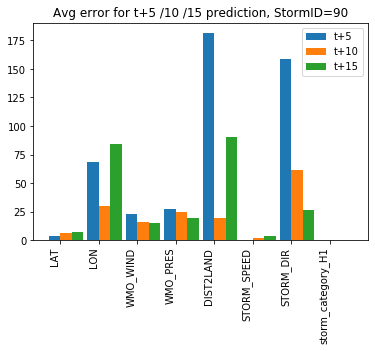

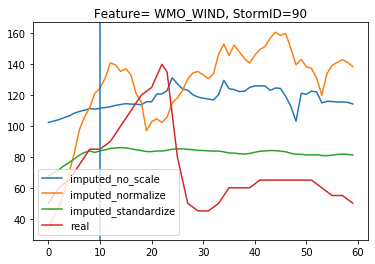

In [178]:
#60 is big storm not easy to predict
storm_id = 90
time = 10
r = 22 #size of latent features 
p = 2 #plot predicted feature 
test(t3, p_list, storm_id, time, r, p )

Code stopped at iteration = 50, and mae difference = 14.964157104492188
Code stopped at iteration = 50, and mae difference = 8.607124328613281
Code stopped at iteration = 50, and mae difference = 9.620162963867188
Code stopped at iteration = 50, and mae difference = 8.3871488571167
Code stopped at iteration = 50, and mae difference = 10.973583221435547
Code stopped at iteration = 50, and mae difference = 11.79088306427002
Code stopped at iteration = 50, and mae difference = 76.28543090820312
Code stopped at iteration = 50, and mae difference = 22.177278518676758
Code stopped at iteration = 50, and mae difference = 27.48775291442871
Code stopped at iteration = 50, and mae difference = 30.0114688873291
Code stopped at iteration = 50, and mae difference = 37.64927673339844
Code stopped at iteration = 50, and mae difference = 55.307437896728516
Code stopped at iteration = 50, and mae difference = 21.298171997070312
Code stopped at iteration = 50, and mae difference = 13.519383430480957
Cod

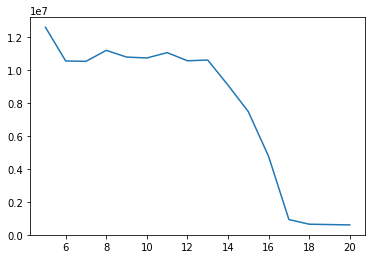

[12587506.0,
 10539923.0,
 10519820.0,
 11185491.0,
 10777224.0,
 10722920.0,
 11047355.0,
 10553948.0,
 10597381.0,
 9072874.0,
 7465449.0,
 4750511.5,
 920587.125,
 638400.375,
 616043.0625,
 595103.1875]

In [35]:
#get best r
def get_best_r(data, r_min, r_max):
    r_list = []
    for r in range(r_min, r_max):
        X_imputed = slice_learning(data,r, plot = False)
        r_list.append(get_mae(X_imputed,data))
    plt.plot([r for r in range(r_min, r_max)], r_list)
    plt.show()
    return r_list

get_best_r(t3[:,2:22,:], 5, 21)

In [76]:
r=5
m,n,t=t3.shape

#SVD 
def mat_svd(X,r):
    #Mode-1 folding
    X1= X.reshape(m,n*t)
    U,S,V= torch.svd(X1,some=True, compute_uv=True) 
    U1=U[:,:r]
    #Mode-2 folding
    X2= X.reshape(m*t,n) 
    U,S,V= torch.svd(X2,some=True, compute_uv=True)
    V1=V[:,:r]
    return U1,V1

#Update S based on U1, V1
def update_s(U, X, V, r ):
    new_s = torch.empty((r,r,t))
    for i in range(t): 
        m1 = torch.mm(torch.t(U),X[:,:,i]) #torch.t = transpose
        m2 = torch.mm(m1,V)
        new_s[:,:,i]=m2
    return new_s

#Compute Z:
def update_z(U,V,S):
    new_z = torch.empty((m,n,t))
    for i in range(t): 
        S_t=S[:,:,i]
        m1 = torch.mm(U,S_t)
        m2 = torch.mm(m1,torch.t(V))
        new_z[:,:,i]=m2
    return new_z

#wrap up everything 
def tensor_svd1(Z0,r,T=50):
    
    #initialise R
    R=torch.rand(Z0.shape)
    error=100
    error_all=[]
    
    for t in range(T):
        if error > 1: 
            U1,V1= mat_svd(R,r)
            S=update_s(U1,R,V1,r)
            Z1=update_z(U1,V1,S)
            R=Z1
            #calculate error 
            error=(Z1-Z0).pow(2).sum().item()
            error_all.append(error)
    
    print('code stopped at t=%s at error=%s'%(t,error))
    
    #plot error 
    L=len(error_all)
    plt.plot(np.linspace(1,L,L),error_all)
    plt.show()
    
    return Z1    


code stopped at t=49 at error=15690701824.0


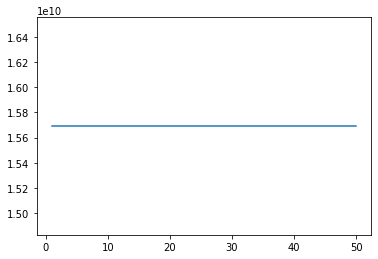

tensor([[[0.5016, 0.5122, 0.4775,  ..., 0.3260, 0.3831, 0.4205],
         [0.5777, 0.3512, 0.5583,  ..., 0.3851, 0.5314, 0.3812],
         [0.5273, 0.4193, 0.4554,  ..., 0.4396, 0.5367, 0.3923],
         [0.4839, 0.6461, 0.5778,  ..., 0.4843, 0.6149, 0.3576],
         [0.6038, 0.4567, 0.4720,  ..., 0.6169, 0.4439, 0.5110]],

        [[0.4729, 0.4610, 0.5487,  ..., 0.4879, 0.5260, 0.6021],
         [0.5083, 0.5050, 0.5018,  ..., 0.4844, 0.4903, 0.4901],
         [0.4997, 0.5932, 0.4719,  ..., 0.4831, 0.5269, 0.4114],
         [0.5306, 0.4577, 0.4402,  ..., 0.5177, 0.6059, 0.4925],
         [0.4675, 0.5287, 0.5318,  ..., 0.5700, 0.4741, 0.3571]],

        [[0.3969, 0.5138, 0.4801,  ..., 0.2843, 0.3513, 0.3843],
         [0.5841, 0.3788, 0.5527,  ..., 0.4366, 0.4922, 0.3908],
         [0.5734, 0.3260, 0.4945,  ..., 0.4741, 0.5016, 0.5148],
         [0.5089, 0.6680, 0.6155,  ..., 0.5222, 0.5942, 0.2782],
         [0.5909, 0.4051, 0.4410,  ..., 0.5779, 0.5096, 0.6712]],

        ...,

     

In [81]:
tensor_svd1(t3,5)

In [108]:
x = torch.rand(2,3,4)
print('x=',x)
#     m,n,t = x.shape
#     mean = torch.zeros(m,n)
#     std = torch.zeros(m,n)
#     for i in range(m):
#     for j in range(n):
#         mean[i,j] = x[i,j,:].mean()
#         std[i,j] = x[i,j,:].std() 
#     print ('loop result',std,mean)

#calculate standard deviation and mean of tensor
def standardize(tensor):
    new_tensor = tensor.clone()
    #calculate along 2nd (python index) dimension 
    std, mean = torch.std_mean(tensor, dim=2)
    t=tensor.shape[2]
    for i in range(t):
        #element wise division
        new_tensor[:,:,i] = torch.div((tensor[:,:,i] - mean),std) 
    return new_tensor, mean, std

def de_standardize(tensor,mean,std):
    t=tensor.shape[2]
    new_tensor = tensor.clone()
    for i in range(t):
        #element wise multiplication
        new_tensor[:,:,i] = torch.mul(tensor[:,:,i] ,std) + mean 
    return new_tensor 
a,m,std=standardize(x)
b=de_standardize(a,m,std) 
print('standardize',a )
print('de_standardize', b)
 
    
torch.svd(a,some=True, compute_uv=True)

x= tensor([[[0.5615, 0.7745, 0.5196, 0.1971],
         [0.4803, 0.2405, 0.8677, 0.1691],
         [0.9701, 0.2670, 0.7489, 0.4611]],

        [[0.3868, 0.8901, 0.8582, 0.4788],
         [0.8212, 0.8500, 0.5475, 0.3127],
         [0.5471, 0.7128, 0.4886, 0.6708]]])
standardize tensor([[[ 0.2027,  1.0959,  0.0270, -1.3256],
         [ 0.1297, -0.6313,  1.3596, -0.8580],
         [ 1.1550, -1.1113,  0.4419, -0.4855]],

        [[-1.0339,  0.9174,  0.7940, -0.6775],
         [ 0.7436,  0.8576, -0.3370, -1.2642],
         [-0.5518,  1.0320, -1.1105,  0.6303]]])
de_standardize tensor([[[0.5615, 0.7745, 0.5196, 0.1971],
         [0.4803, 0.2405, 0.8677, 0.1691],
         [0.9701, 0.2670, 0.7489, 0.4611]],

        [[0.3868, 0.8901, 0.8582, 0.4788],
         [0.8212, 0.8500, 0.5475, 0.3127],
         [0.5471, 0.7128, 0.4886, 0.6708]]])


torch.return_types.svd(
U=tensor([[[-0.0712,  0.9577,  0.2790],
         [-0.7132,  0.1467, -0.6854],
         [-0.6973, -0.2478,  0.6726]],

        [[-0.6969,  0.0643,  0.7143],
         [-0.6632,  0.3214, -0.6760],
         [-0.2731, -0.9447, -0.1814]]]),
S=tensor([[2.2086, 1.7784, 0.9795],
        [1.9129, 1.7228, 1.5404]]),
V=tensor([[[-0.4131, -0.0411,  0.7600],
         [ 0.5194,  0.6929, -0.0092],
         [-0.5794,  0.0651, -0.6403],
         [ 0.4731, -0.7169, -0.1106]],

        [[ 0.1977,  0.4027, -0.7408],
         [-0.7788, -0.3717, -0.0724],
         [-0.0139,  0.5757,  0.6468],
         [ 0.5951, -0.6068,  0.1664]]]))

In [ ]:
#to use in the future: computes the wind category
def sust_wind_to_cat(wind):
    # maximum sustained wind in kt (knot)
    if wind<=33: cat='TD' # <=33
    elif wind<=63.:  cat='TS'
    elif wind <=82.: cat='H1'
    elif wind <=95.: cat='H2'
    elif wind <=112.: cat='H3'
    elif wind <=136.: cat='H4'
    else: cat='H5'

    return cat

In [193]:
#allows to keep only the data between two dates to specify
def get_periodic_data(data, start ='2018-01-01',end ='2018-12-31',mincat=None,maxcat=None):
    n = len(data)
    start = datetime.strptime(start, '%Y-%m-%d')
    end = datetime.strptime(end, '%Y-%m-%d')
    times = pd.to_datetime(data['ISO_TIME'][1:n])
    ind_start = 1
    ind_end = n
    i = 1
    while times[i] < start :#or i < n:
        i+=1
    ind_start = i
    while times[i] < end :#or i < n:
        i+=1
    ind_end = i
    return data[ind_start:ind_end]

In [190]:
#allows to get the distinct ids of the storms 
def get_ids(data):
    return data.SID.unique()

In [6]:
def get_storm_track(data, storm_id = '2016005N02187', time_step = 6):
    #data.set_index("SID", inplace=True)
    return data.loc[data['SID'] == storm_id]

In [8]:
storm = get_storm_track(data)
lat = np.array(storm['LAT'])
lat2 = [float(lat[i]) for i in range(len(lat))]
lon = np.array(storm['LON'])
lon2 = [float(lon[i]) for i in range(len(lon))]

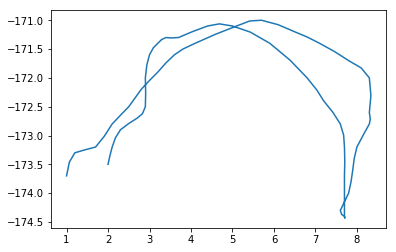

In [9]:
plt.plot(lat2, lon2)
plt.show()

Some functions we may use

In [5]:
def get_distance_km(lon1, lat1, lon2, lat2):
    '''
    Using haversine formula (https://www.movable-type.co.uk/scripts/latlong.html)
    '''
    R=6371e3 # meters (earth's radius)
    phi_1=math.radians(lat1)
    phi_2 = math.radians(lat2)
    delta_phi=math.radians(lat2-lat1)
    delta_lambda=math.radians(lon2-lon1)
    a=np.power(math.sin(delta_phi/2),2) + math.cos(phi_1)*math.cos(phi_2)\
      * np.power(math.sin(delta_lambda/2),2)
    c= 2 * math.atan2(math.sqrt(a),math.sqrt(1-a))

    return R*c/1000.


def get_longlat_from_offsets(lon, lat, dkm_lon, dkm_lat):
    '''
    :param lon: initial longitude
    :param lat: inital latitude
    :param dn:     offsets in meters
    :param de:     offsets in meters
    :return: lon_final, lat_final
    '''
    # Earth’s radius, sphere
    R = 6378137
    # Coordinate offsets in radians
    dLat = dkm_lat / R
    dLon = dkm_lon / (R * math.cos(math.radians(lat)))

    # OffsetPosition, decimal degrees
    latO = lat + dLat * 180 / math.pi
    lonO = lon + dLon * 180 / math.pi

    return lonO, latO